In [1]:
from google.colab import files
uploaded = files.upload()

Saving AB_NYC_2019.csv to AB_NYC_2019.csv


In [2]:
import pandas as pd

df = pd.read_csv("AB_NYC_2019.csv")

print(df.shape)
df.head()

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
df = df.drop(columns=["host_id",
                      "host_name",
                      "last_review",
                      "reviews_per_month"])

print(df.shape)
df.head()

(48895, 12)


,id,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2595,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,3831,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


In [4]:
df = df[["id",
         "name",
         "neighbourhood_group",
         "neighbourhood",
         "latitude",
         "longitude",
         "room_type",
         "minimum_nights",
         "number_of_reviews",
         "calculated_host_listings_count",
         "availability_365",
         "price"]]

print(df.shape)
df.head()

(48895, 12)


,id,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price
0,2539,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,1,9,6,365,149
1,2595,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2,355,225
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,3,0,1,365,150
3,3831,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,270,1,194,89
4,5022,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,9,1,0,80


In [5]:
# NANs
df.isnull().sum()

id                                 0
name                              16
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
minimum_nights                     0
number_of_reviews                  0
calculated_host_listings_count     0
availability_365                   0
price                              0
dtype: int64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


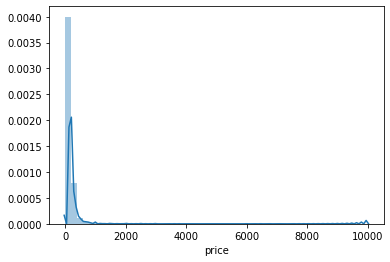

In [6]:
import seaborn as sns
%matplotlib inline

# DistPlot -- Price
sns.distplot(df["price"], bins=50);

##Data Manipulation & Preprocessing

Given that the above graph is extremely skewed to the right,
we will be conveting the price to log(price) in order to compensate

In [7]:
# Since log(0) = -inf, we will remove the zeroes from the graph.

# Shrinking DF
df = df[df["price"] > 0]

# CHECK:
print(df.shape)
df.head()

(48884, 12)


,id,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price
0,2539,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,1,9,6,365,149
1,2595,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2,355,225
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,3,0,1,365,150
3,3831,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,270,1,194,89
4,5022,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,9,1,0,80


In [8]:
import numpy as np

df["log_price"] = np.log(df.price.values)

print(df.shape)
df.head()

(48884, 13)


,id,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price,log_price
0,2539,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,1,9,6,365,149,5.003946
1,2595,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2,355,225,5.416100
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,3,0,1,365,150,5.010635
3,3831,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,270,1,194,89,4.488636
4,5022,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,9,1,0,80,4.382027


In [9]:
df.log_price.describe()

count    48884.000000
mean         4.727031
std          0.698225
min          2.302585
25%          4.234107
50%          4.663439
75%          5.164786
max          9.210340
Name: log_price, dtype: float64

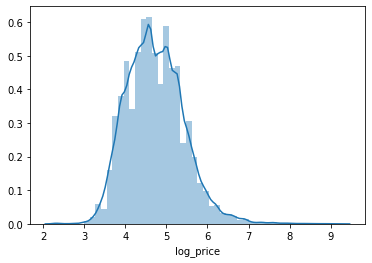

In [10]:
#DistPlot - log_price

# This distribution is clearly far more
# normal than the previous one was.
sns.distplot(df["log_price"], bins=50);

In [11]:
df.head()

,id,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price,log_price
0,2539,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,1,9,6,365,149,5.003946
1,2595,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2,355,225,5.416100
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,3,0,1,365,150,5.010635
3,3831,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,270,1,194,89,4.488636
4,5022,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,9,1,0,80,4.382027


In [12]:
# Shuffling the DataFrame
from sklearn.utils import shuffle

df_shuffled = shuffle(df, random_state=84)
df_shuffled = df_shuffled.reset_index(drop=True)
df_shuffled.head()

,id,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price,log_price
0,33782653,Packaged for one plus groups (ENSUITE KING ROYAL),Brooklyn,East Flatbush,40.64695,-73.93121,Private room,2,3,4,365,100,4.605170
1,11885997,Beautiful loft in DUMBO Brooklyn,Brooklyn,Vinegar Hill,40.70211,-73.98418,Entire home/apt,2,3,2,0,245,5.501258
2,894015,Boldera: Your Home Away From Home,Brooklyn,Bedford-Stuyvesant,40.68194,-73.92896,Entire home/apt,2,147,1,27,107,4.672829
3,4644669,Upper East Side,Manhattan,Upper East Side,40.76358,-73.96464,Entire home/apt,5,64,1,330,325,5.783825
4,6198343,Calm airy top floor W'burgh 1.5 bed,Brooklyn,Williamsburg,40.71776,-73.94538,Entire home/apt,3,30,1,364,200,5.298317


In [13]:
# Encoding prior to train_test_split could
# potentially save us a headache down the road.

# Features and Target
target = "log_price"
features = ["neighbourhood_group",
            "neighbourhood",
            "latitude",
            "longitude",
            "room_type",
            "minimum_nights",
            "number_of_reviews",
            "calculated_host_listings_count",
            "availability_365"]

X = df_shuffled[features]
y = df_shuffled[target]

X.shape, y.shape

((48884, 9), (48884,))

###Preprocessing

In [14]:
X.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,East Flatbush,40.64695,-73.93121,Private room,2,3,4,365
1,Brooklyn,Vinegar Hill,40.70211,-73.98418,Entire home/apt,2,3,2,0
2,Brooklyn,Bedford-Stuyvesant,40.68194,-73.92896,Entire home/apt,2,147,1,27
3,Manhattan,Upper East Side,40.76358,-73.96464,Entire home/apt,5,64,1,330
4,Brooklyn,Williamsburg,40.71776,-73.94538,Entire home/apt,3,30,1,364


In [15]:
X.room_type.value_counts(normalize=True)

Entire home/apt    0.519741
Private room       0.456571
Shared room        0.023689
Name: room_type, dtype: float64

In [16]:
# We will manually encode room_type,
# then apply ordinal encoding to the
# neighbourhood_group and neighborhood columns

X_encoded = X.replace({"room_type" : {"Shared room" : 0, "Private room" : 1, "Entire home/apt" : 2}})

X_encoded.room_type.value_counts(normalize=True)

2    0.519741
1    0.456571
0    0.023689
Name: room_type, dtype: float64

In [17]:
X_encoded.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,East Flatbush,40.64695,-73.93121,1,2,3,4,365
1,Brooklyn,Vinegar Hill,40.70211,-73.98418,2,2,3,2,0
2,Brooklyn,Bedford-Stuyvesant,40.68194,-73.92896,2,2,147,1,27
3,Manhattan,Upper East Side,40.76358,-73.96464,2,5,64,1,330
4,Brooklyn,Williamsburg,40.71776,-73.94538,2,3,30,1,364


In [18]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.3MB/s 


In [19]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

prep_pipeline = make_pipeline(
    OrdinalEncoder(),
    StandardScaler()
)

X_prep = prep_pipeline.fit_transform(X_encoded)
(type(X_prep), X_prep.shape)

(numpy.ndarray, (48884, 9))

In [20]:
X_train = X_prep[:int(len(y) * 0.8)]
X_test = X_prep[int(len(y) * 0.8):]

y_train = y[:int(len(y) * 0.8)]
y_test = y[int(len(y) * 0.8):]

print(X_train.shape, y_train.shape)
X_test.shape, y_train.shape

(39107, 9) (39107,)


((9777, 9), (39107,))

In [42]:
y_train

0        4.605170
1        5.501258
2        4.672829
3        5.783825
4        5.298317
           ...   
39102    5.010635
39103    3.806662
39104    4.828314
39105    4.094345
39106    5.298317
Name: log_price, Length: 39107, dtype: float64

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

train_pred = xgb.predict(X_train)
test_pred = xgb.predict(X_test)

# Reporting Metrics
mse = mean_squared_error(y_train, train_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, train_pred)
r2 = r2_score(y_train, train_pred)

print("Training Metrics")
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R^2:', r2, "\n")

mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

print("---" * 4)

print("\nTest Metrics")
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R^2:', r2)

[20:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Metrics
Mean Absolute Error: 0.3189390276789132
Mean Squared Error: 0.19725875667362408
Root Mean Squared Error: 0.4441382179835733
R^2: 0.5956525500143157 

------------

Test Metrics
Mean Absolute Error: 0.32381071466618705
Mean Squared Error: 0.2056978755900147
Root Mean Squared Error: 0.45353927678869743
R^2: 0.5767972417498826


In [43]:
train_pred

array([4.399145 , 5.161812 , 4.7525077, ..., 5.0629773, 4.22674  ,
       4.977244 ], dtype=float32)

In [36]:
# y_test, test_pred,

# Defining Function
def function(y_vector, y_pred_vector):
  
  # Training Data
  log_price = pd.DataFrame(y_vector, columns=["log_price"])
  log_price_pred = pd.DataFrame(y_pred_vector, columns=["log_price_pred"])

  unlog_price = np.exp(log_price.values)
  unlog_price = pd.DataFrame(unlog_price, columns=["unlog_price"])

  unlog_pred_price = np.exp(log_price_pred.values)
  unlog_pred_price = pd.DataFrame(unlog_pred_price, columns=["unlog_pred_price"])


  df_logs = pd.concat([log_price, log_price_pred, unlog_price, unlog_pred_price], 
                       axis=1)
  
  return df_logs


# CHECK:
df = function(y_train, train_pred)


In [37]:
# CHECK:
print(df.shape)
df.head()

(39107, 4)


,log_price,log_price_pred,unlog_price,unlog_pred_price
0,4.605170,4.399145,100.0,81.381271
1,5.501258,5.161812,245.0,174.480301
2,4.672829,4.752508,107.0,115.874496
3,5.783825,5.505877,325.0,246.134232
4,5.298317,5.414953,200.0,224.742035


In [45]:
df.tail()

,log_price,log_price_pred,unlog_price,unlog_pred_price
39102,5.010635,5.262779,150.0,193.017181
39103,3.806662,4.208181,45.0,67.234154
39104,4.828314,5.062977,125.0,158.060410
39105,4.094345,4.226740,60.0,68.493568
39106,5.298317,4.977244,200.0,145.073990


In [38]:
df.isnull().sum()

log_price           0
log_price_pred      0
unlog_price         0
unlog_pred_price    0
dtype: int64

In [46]:
# CHECK: Testing
dfx = function(y_test, test_pred)
dfx.reset_index(drop=True)

,log_price,log_price_pred,unlog_price,unlog_pred_price
0,NaN,4.167329,50.0,64.542816
1,NaN,4.323561,56.0,75.456833
2,NaN,5.644320,230.0,282.681396
3,NaN,5.524573,261.0,250.779312
4,NaN,4.043390,45.0,57.019299
...,...,...,...,...
19549,5.521461,NaN,NaN,NaN
19550,3.688879,NaN,NaN,NaN
19551,4.605170,NaN,NaN,NaN
19552,3.912023,NaN,NaN,NaN


In [44]:
y_test

39107    3.912023
39108    4.025352
39109    5.438079
39110    5.564520
39111    3.806662
           ...   
48879    5.521461
48880    3.688879
48881    4.605170
48882    3.912023
48883    5.293305
Name: log_price, Length: 9777, dtype: float64

In [40]:
print(dfx.shape)
dfx.head()

(19554, 4)


,log_price,log_price_pred,unlog_price,unlog_pred_price
0,NaN,4.167329,50.0,64.542816
1,NaN,4.323561,56.0,75.456833
2,NaN,5.644320,230.0,282.681396
3,NaN,5.524573,261.0,250.779312
4,NaN,4.043390,45.0,57.019299


In [41]:
dfx.tail()

,log_price,log_price_pred,unlog_price,unlog_pred_price
48879,5.521461,NaN,NaN,NaN
48880,3.688879,NaN,NaN,NaN
48881,4.605170,NaN,NaN,NaN
48882,3.912023,NaN,NaN,NaN
48883,5.293305,NaN,NaN,NaN


In [27]:
# Pickling our best model

from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [ ]:
import pickle

xgb_string = pickle.dumps(xgb)
xgb_string

In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb).fit(X_train, y_train)
eli5.show_weights(perm)

In [ ]:
importances = [features[4],
               features[3],
               features[2],
               features[8],
               features[5],
               features[6],
               features[7],
               features[1],
               features[0]]

importances

##Neural Networks

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
                    Dense(16, input_dim=9, activation="sigmoid"),
                    Dense(16, activation="sigmoid"),
                    Dense(1)
])

model.compile(loss="mean_absolute_error", optimizer="adam")
model.fit(x=X_train,
          y=y_train,
          epochs=50,
          validation_data=(X_test, y_test),
          verbose=1)

###Hyperparameter tuning

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

# Defining Function
def create_model(layers=2, nodes=16, activation_type="relu", dropout=True):
    '''
    Creates a model instance with the specified attributes
    '''
    # Instantiate Model
    model = Sequential()
    
    # Input Layer
    model.add(Dense(9, input_dim=9, activation=activation_type))
    
    # Hidden Layers
    for i in range(layers):
      model.add(Dense(nodes, activation=activation_type))
      if dropout == True:
        model.add(Dropout(0.2))
    
    # Output Layer
    model.add(Dense(1))
    
    # Compile model
    model.compile(loss=["mae", "mse"],
                  optimizer="adam",
                  metrics=["mae", "mse"])
    
    return model

# Creating Classifier Model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Parameters
param_grid = {'layers': [2],
              'nodes': [16],
              'batch_size': [2, 4, 8, 16, 32],
              'activation_type': ['sigmoid']}

# RandomizedSearchCV
search = RandomizedSearchCV(estimator=model,
                            param_distributions=param_grid,
                            n_jobs=-1,
                            cv=5)

# Search Results
search_result = search.fit(X_train, y_train)

# Report Results
def reporting(search_results):
  print(f'Best {search_results.best_score_} using {search_results.best_params_}')
  means = search_results.cv_results_["mean_test_score"]
  stds = search_results.cv_results_["std_test_score"]
  params = search_results.cv_results_["params"]
  for mean, stdev, param in zip(means, stds, params):
    print(f"Mean :{mean}, Stdev:{stds}, with:{param}")

reporting(search_result)